In [2]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [49]:
image = np.asarray(Image.open('china-original.png').convert('L'))

In [ ]:
def adjust_brightness(image, brightness):
    return np.clip(image * brightness**4, 0, 255).astype(np.uint8)

brightness_slider = widgets.FloatSlider(
    value=1.0,
    min=0,
    max=2,
    step=0.1,
    description='Brightness:',
    continuous_update=True
)

def update_brightness(brightness):
    adjusted_image = adjust_brightness(image, brightness)
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.imshow(adjusted_image,cmap='gray')
    ax1.axis('off')
    ax2.hist(adjusted_image.ravel(),255,density=1,range=(0,255))
    ax2.set_title('image histogram')
    plt.tight_layout()
    plt.show()

widgets.interact(update_brightness, brightness=brightness_slider)

interactive(children=(FloatSlider(value=1.0, description='Brightness:', max=2.0), Output()), _dom_classes=('wi…

<function __main__.update_brightness(brightness)>

In [ ]:
def adjust_contrast(image, contrast):    
    return np.clip(image + (image - np.mean(image)) * np.sin(contrast), 0, 255).astype(np.uint8)

contrast_slider = widgets.FloatSlider(
    value=0,
    min=-1,
    max=1,
    step=0.1,
    description='Contrast:',
    continuous_update=True
)

def update_contrast(contrast):
    adjusted_image = adjust_contrast(image, contrast)
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.imshow(adjusted_image, cmap='grey')
    ax1.axis('off')
    ax2.hist(adjusted_image.ravel(),255,density=1,range=(0,255))
    ax2.set_title('image histogram')
    plt.tight_layout()
    plt.show()

widgets.interact(update_contrast, contrast=contrast_slider)

interactive(children=(FloatSlider(value=0.0, description='Contrast:', max=1.0, min=-1.0), Output()), _dom_clas…

<function __main__.update_contrast(contrast)>

### Windowing can enahnce part of an image.(If it is recognizable from it's histogram. e.g, the bottom right tree)
### 10 - 30 is a decent range.

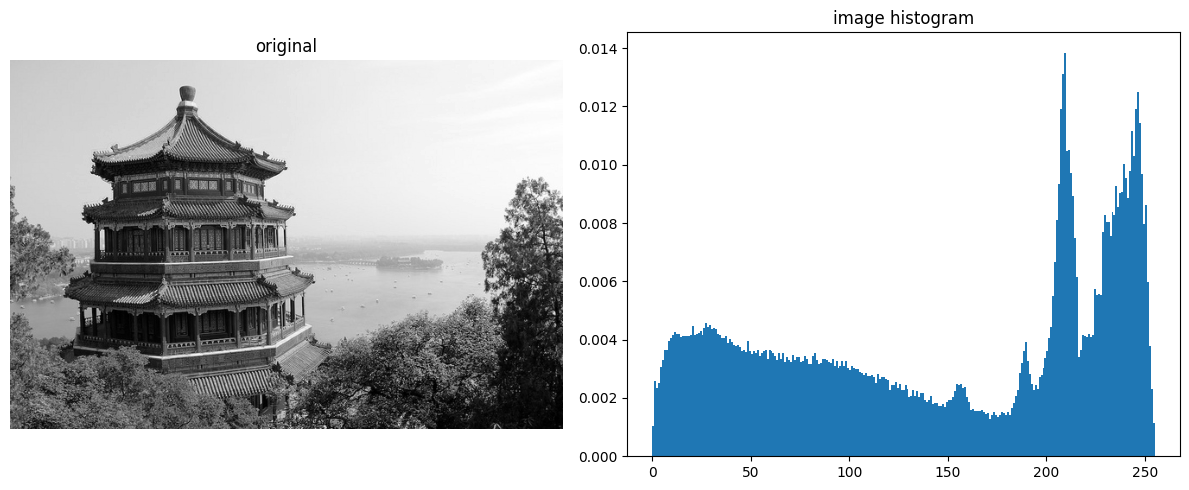

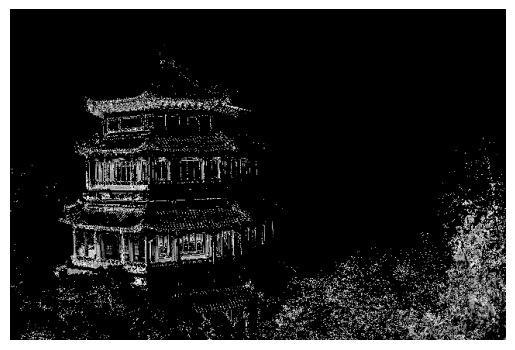

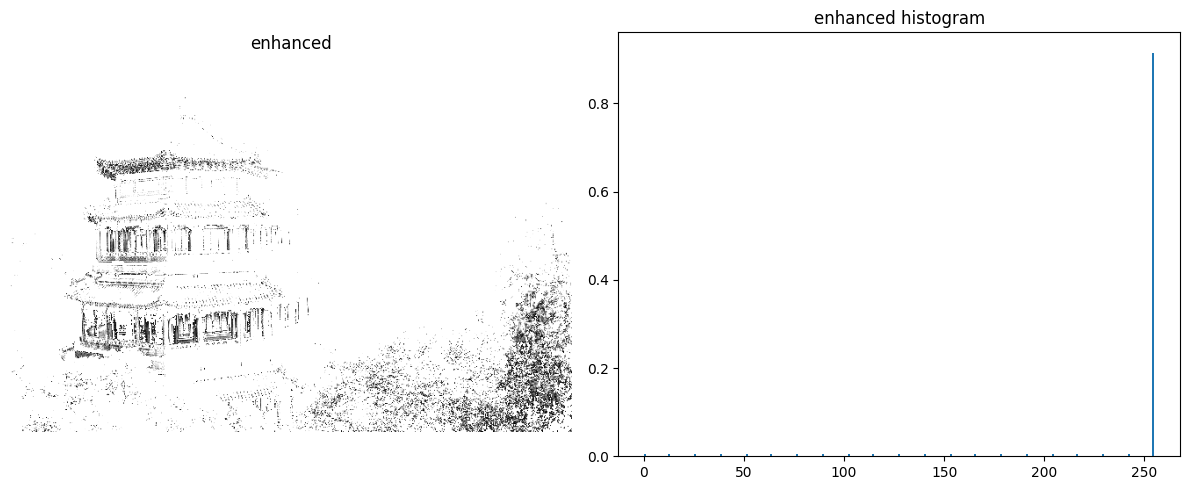

In [5]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.imshow(image, cmap='grey')
ax1.set_title('original')
ax1.axis('off')
ax2.set_title('image histogram')
ax2.hist(image.ravel(),255,density=1,range=(0,255))
plt.tight_layout()
plt.show()

temp = image.copy()
temp[(10 > temp) | (temp > 30)] = 0
plt.imshow(temp, cmap='grey')
plt.axis('off')
plt.show()

# Seems like 10-30 range captures the bottom right tree

enhanced_image = np.clip(255/(30 - 10) * (image - 10),0,255)
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.imshow(enhanced_image, cmap='grey')
ax1.set_title('enhanced')
ax1.axis('off')
ax2.set_title('enhanced histogram')
ax2.hist(enhanced_image.ravel(),255,density=1,range=(0,255))
plt.tight_layout()
plt.show()


### Suppose we want to enhance a darkened image.
### Windowing solves the problem by expanding the collapsed histogram.

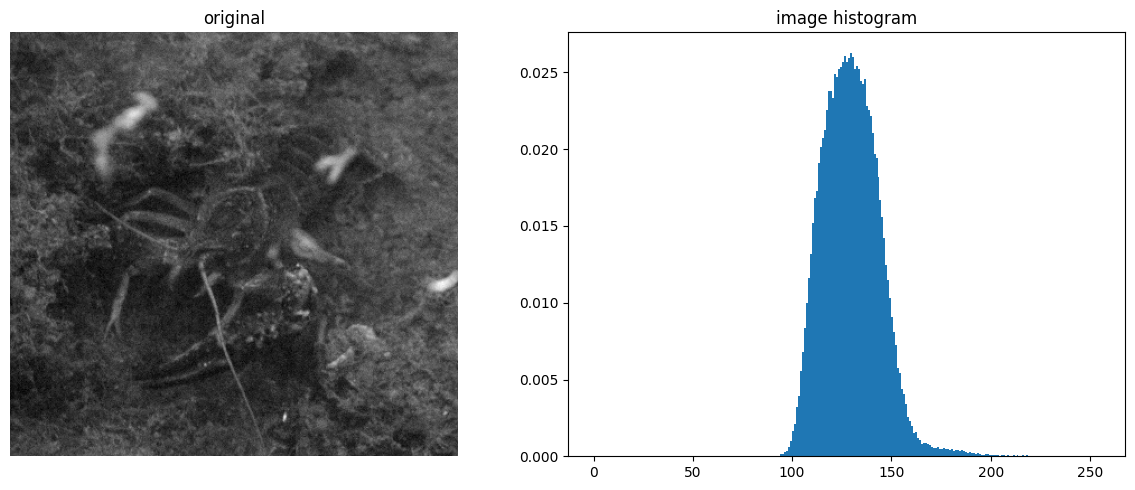

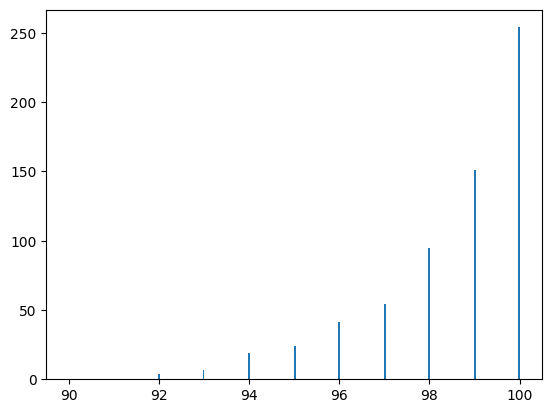

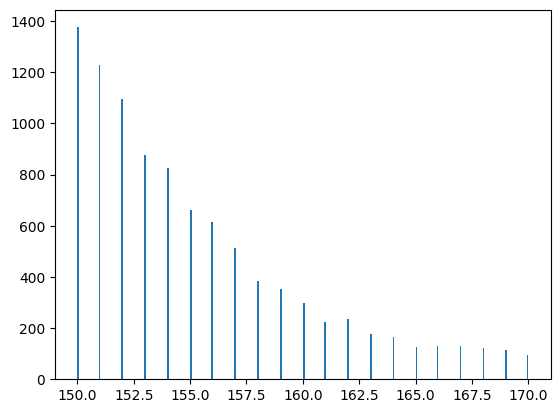

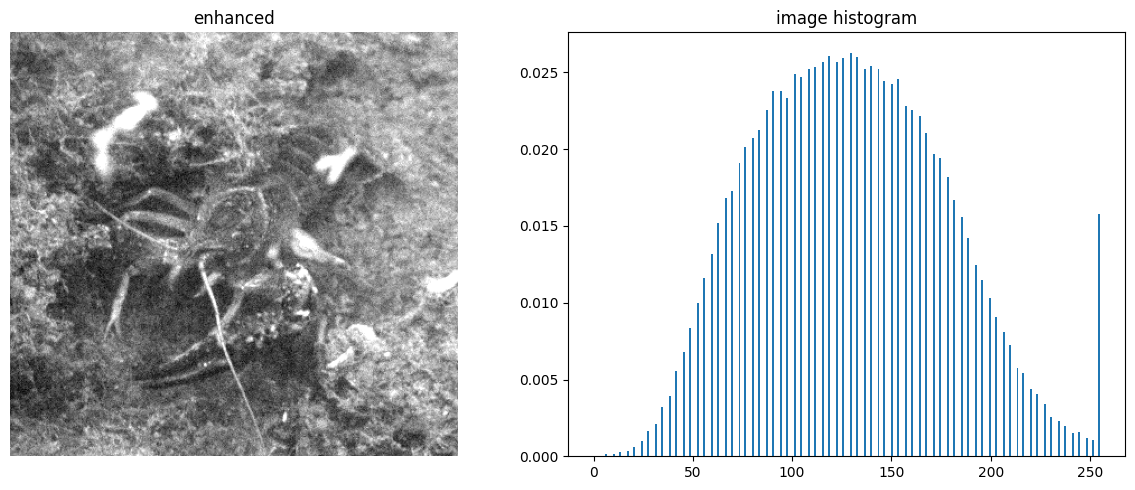

In [4]:
bad_image1 = plt.imread('crayfish.jpg')
enhanced_image = np.clip((bad_image1 - 92) / 73 * 255, 0, 255).astype(np.uint8)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.imshow(bad_image1, cmap='grey')
ax1.set_title('original')
ax1.axis('off')
ax2.set_title('image histogram')
ax2.hist(bad_image1.ravel(),255,density=1,range=(0,255))
plt.tight_layout()
plt.show()
plt.hist(bad_image1.ravel(),256,[90,100])
plt.show()
plt.hist(bad_image1.ravel(),256,[150,170])
plt.show()
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.imshow(enhanced_image,cmap='gray')
ax1.set_title('enhanced')
ax1.axis('off')
ax2.set_title('image histogram')
ax2.hist(enhanced_image.ravel(),255,density=1,range=(0,255))
plt.tight_layout()
plt.show()

### a simple approach to calculate lower and upper bound for windowing:

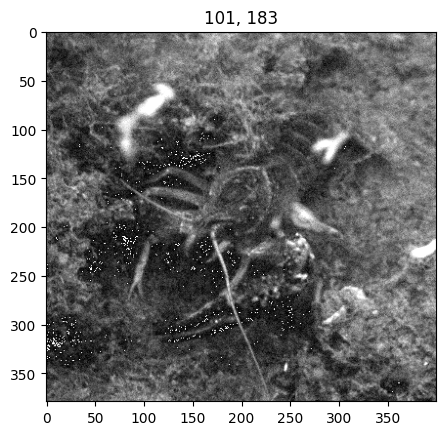

In [7]:
def find_boundaries(image, eps):
    hist = np.zeros(256)
    for row in image:
        for intensity in row:
            hist[intensity] += 1
    normalized_cdf = np.cumsum(hist) / image.size
    a = np.argwhere(normalized_cdf >= (1-eps)/2)[0, 0]
    b = np.argwhere(normalized_cdf >= 1-(1-eps)/2)[0, 0]
    return a, b

a, b = find_boundaries(bad_image1, .99)
windowed_image = np.clip((bad_image1 - a) / (b - a), 0, 1)
plt.title(f'{a}, {b}')
plt.imshow(windowed_image, 'gray', vmin=0, vmax=1)
plt.show()

### Suppose we want to enhance a high contrast image. Windowing will not work since the original histogram range is almost full.
### Histogram Equalization will save the day!

In [102]:
def calc_hist(I, levels):
    hist = np.zeros(levels)
    for row in I:
        for intensity in row:
            hist[intensity] += 1
    return hist

def calc_cdf(hist):
    cdf = np.zeros_like(hist)
    cdf[0] = hist[0]
    for i in range(1, len(hist)):
        cdf[i] = cdf[i-1] + hist[i]
    return cdf

def equalizeHist(I, levels):
    hist = calc_hist(I, levels)
    cdf = calc_cdf(hist)
    mapping = np.floor(cdf * 255 / I.size)
    equalized_image = mapping[I.ravel()].astype(np.uint8).reshape(I.shape)

    fig = plt.figure(figsize= (16, 8))
    fig.add_subplot(2,3,1)
    plt.imshow(I, cmap='gray')
    plt.title('Source image')
    plt.axis('off')

    fig.add_subplot(2,3,2)
    plt.plot(hist)
    plt.title('Source histogram')

    fig.add_subplot(2,3,3)
    plt.plot(cdf)
    plt.title('Source CDF')

    fig.add_subplot(2,3,4)
    plt.imshow(equalized_image, cmap='gray')
    plt.title('Equalized image')
    plt.axis('off')

    fig.add_subplot(2,3,5)
    plt.plot(calc_hist(equalized_image, levels))
    plt.title('Equalized histogram')

    fig.add_subplot(2,3,6)
    plt.plot(calc_cdf(calc_hist(equalized_image, 256)))
    plt.title('Equalized CDF')

    plt.show()

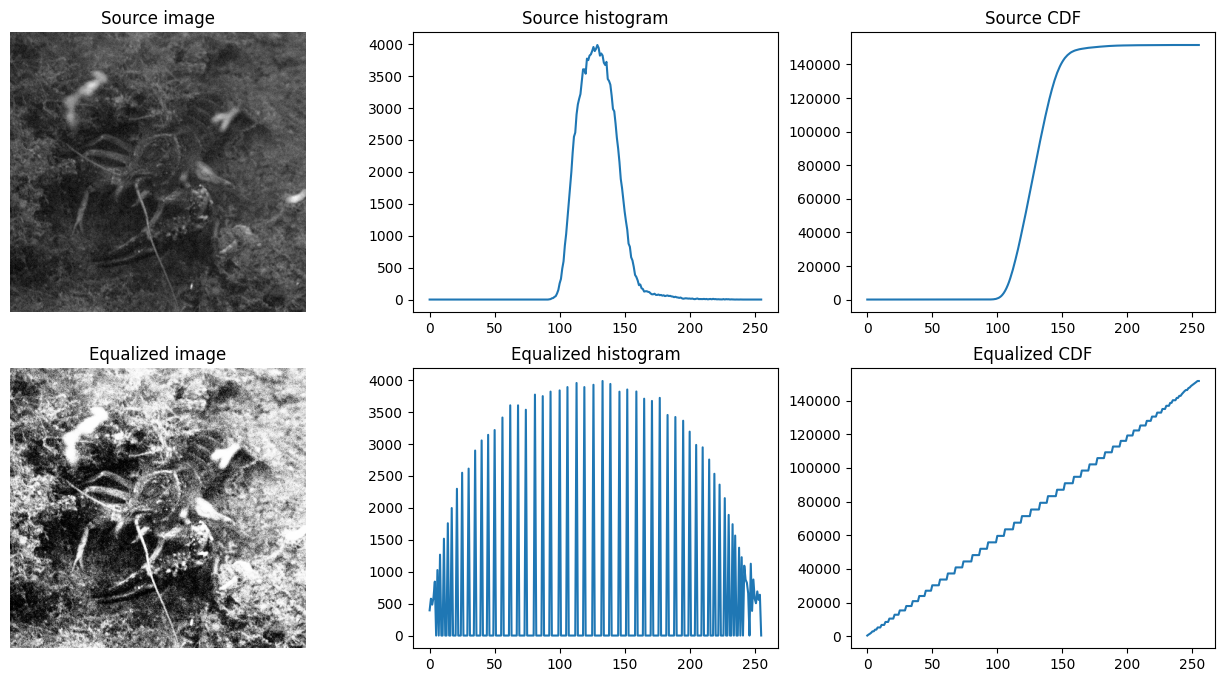

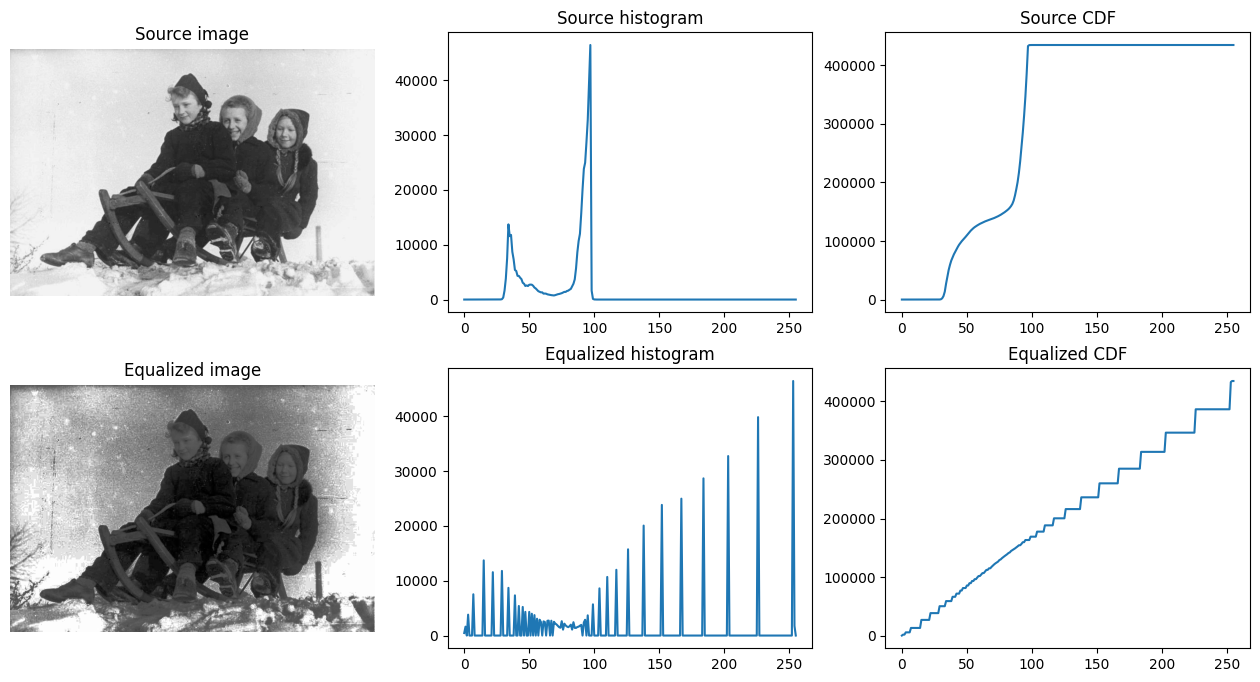

In [107]:
equalizeHist(np.asarray(Image.open('crayfish.jpg').convert('L')), 256)
equalizeHist(np.asarray(Image.open('fam pic.jpg').convert('L')), 256)

### theoretical example

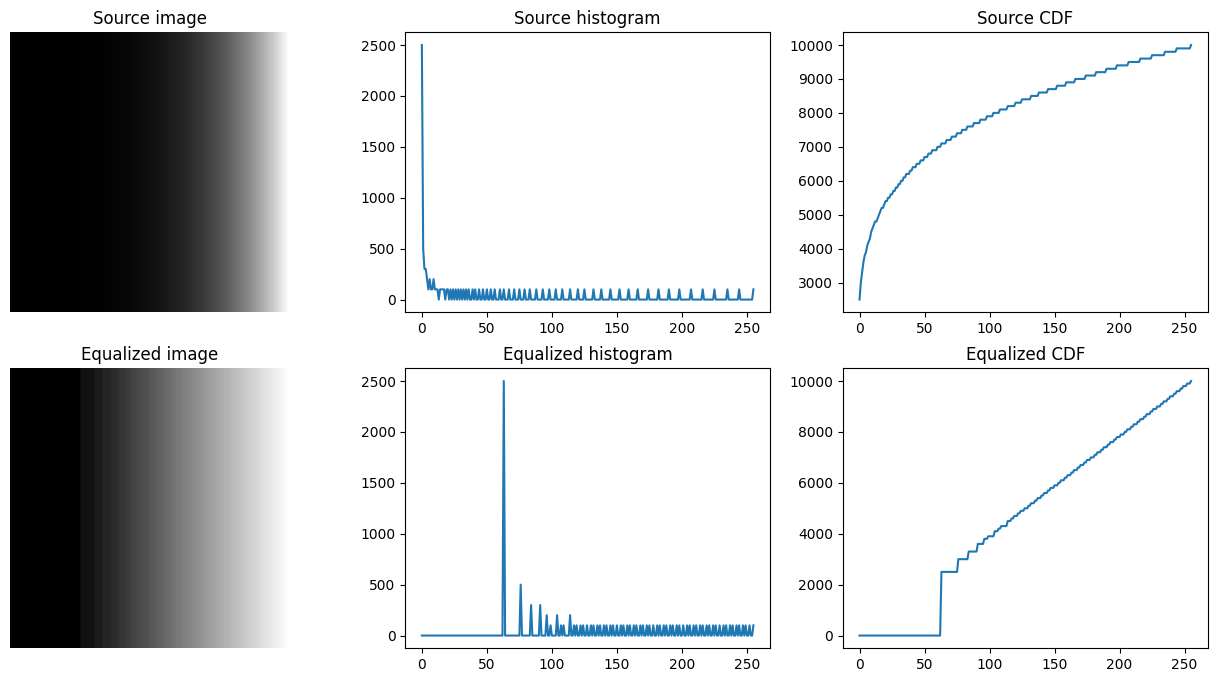

In [106]:
equalizeHist(
    np.tile(
        (255*np.linspace(0, 1, 100)**4).astype(np.uint8)
        , (100, 1))
    , 256)